In [1]:
import os
from PIL import Image
import util.image_import as ii
from glob import glob
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import backend as K
import matplotlib.pyplot as plt
from keras.applications import mobilenet
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, RMSprop, SGD
from util.plots import plot_history
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Trick to configure gpu memory dynamically

In [2]:
cfg = K.tf.ConfigProto() # Config to dynamically add memory
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))# set this TensorFlow session as the default session for Keras.

### Subtracting mean and normalizing to save pictures

In [3]:
# Importing the images
train_pot = glob(os.path.join("../dataset2/res_still/train/potato", "*.jpg"))
train_cat = glob(os.path.join("../dataset2/res_still/train/catfood", "*.jpg"))
train_tab = glob(os.path.join("../dataset2/res_still/train/table", "*.jpg"))
val_pot   = glob(os.path.join("../dataset2/res_still/valid/potato", "*.jpg"))
val_cat   = glob(os.path.join("../dataset2/res_still/valid/catfood", "*.jpg"))
val_tab   = glob(os.path.join("../dataset2/res_still/valid/table", "*.jpg"))
test_pot  = glob(os.path.join("../dataset2/res_still/test/potato", "*.jpg"))
test_cat  = glob(os.path.join("../dataset2/res_still/test/catfood", "*.jpg"))
test_tab  = glob(os.path.join("../dataset2/res_still/test/table", "*.jpg"))

X_train, y_train = ii.images_to_numpy(train_pot, train_cat, train_tab)
X_val, y_val = ii.images_to_numpy(val_pot, val_cat, val_tab)
X_test, y_test = ii.images_to_numpy(test_pot, test_cat, test_tab)

batch_size = 32
num_classes = 3

# Making datagen for training with normilization, center, and dataugmentation
train_datagen = ImageDataGenerator(
        featurewise_center=True,
        #featurewise_std_normalization=True
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35)
)

# Making datagen for validation and test with normilization
valid_datagen = ImageDataGenerator(
        featurewise_center=True, 
        #featurewise_std_normalization=True
        rescale=1./255
)


X_train = X_train.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

# Required for featurewise normalization
train_datagen.fit(X_train/255.)
valid_datagen.fit(X_train/255.)

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=batch_size, shuffle=True)

validation_generator = valid_datagen.flow(X_val,
                                     y_val,
                                     batch_size=batch_size, shuffle=True)

test_generator = valid_datagen.flow(X_test,
                                     y_test,
                                     batch_size=80, shuffle=True)


## Optimized model single run <span style="color:red"> DONE!</span>

In [6]:
model_optimized = Sequential()
model_optimized.add(Flatten(input_shape=(224,224,3)))
model_optimized.add(Dense(256))
model_optimized.add(Activation('relu'))
model_optimized.add(Dense(8))
model_optimized.add(Activation('softmax'))
model_optimized.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4), 
              metrics=['accuracy'])

model_optimized.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               38535424  
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 38,536,195
Trainable params: 38,536,195
Non-trainable params: 0
_________________________________________________________________


In [7]:
history_optimized = model_optimized.fit_generator(
                    train_generator,
                    steps_per_epoch=573 // batch_size,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=160 // batch_size)


Epoch 1/100
17/17 [==============================] - 5s 293ms/step - loss: 2.8243 - acc: 0.3806 - val_loss: 1.3750 - val_acc: 0.4500
Epoch 2/100
17/17 [==============================] - 5s 302ms/step - loss: 1.5000 - acc: 0.5184 - val_loss: 0.7567 - val_acc: 0.5750
Epoch 3/100
17/17 [==============================] - 5s 302ms/step - loss: 1.4416 - acc: 0.5452 - val_loss: 0.7300 - val_acc: 0.6562
Epoch 4/100
17/17 [==============================] - 5s 297ms/step - loss: 1.0899 - acc: 0.6201 - val_loss: 0.6076 - val_acc: 0.7375
Epoch 5/100
17/17 [==============================] - 5s 300ms/step - loss: 0.9730 - acc: 0.6621 - val_loss: 0.7564 - val_acc: 0.6750
Epoch 6/100
17/17 [==============================] - 5s 304ms/step - loss: 0.8690 - acc: 0.6775 - val_loss: 0.5702 - val_acc: 0.7750
Epoch 7/100
17/17 [==============================] - 5s 311ms/step - loss: 0.8384 - acc: 0.6972 - val_loss: 0.5695 - val_acc: 0.8125
Epoch 8/100
17/17 [==============================] - 5s 320ms/step - 

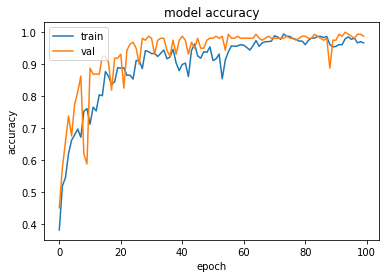

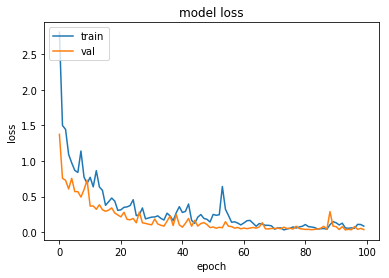

In [8]:
plot_history(history_optimized, save=True, path='nets/feedforward/', name='plot_full')

In [10]:
imgs, labels = next(test_generator)

#ynew = model.predict(imgs)
#results[(lr, lrd, rs, hl)] = (y_train_acc, y_pred_acc)

model_optimized.evaluate(imgs,labels, batch_size=80)

80/80 [==============================] - 0s 638us/step


[0.039275094866752625, 0.987500011920929]

In [ ]:
imgs, labels = next(validation_generator)
history_optimized.predict(imgs)

## Hyperparameter optimization <span style="color:red"> DONE!</span>

In [3]:
# Only work with tensorflow=1.8 and keras=2.1.6 because of the memory allocation

# Hyperparameters
learning_rates = [1e-4, 5e-4];
hidden_size = [128, 256, 512];
history = []
result = None
results = []

for lr in learning_rates:
    for hs in hidden_size:
        # GPU memory allocation
        cfg = K.tf.ConfigProto() # Create setup file for keras tensorflow
        cfg.gpu_options.allow_growth = True # Setting setup file with dynamically adding gpu memory
        K.set_session(K.tf.Session(config=cfg)) # Setting session to use setup file
        sess = tf.Session() 
        K.set_session(sess)# set this TensorFlow session as the default session for Keras.
        
        # Defining the model:
        model = Sequential()
        model.add(Flatten(input_shape=(224,224,3)))
        model.add(Dense(hs))
        model.add(Activation('relu'))
        model.add(Dense(3))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=lr),
                      metrics=['accuracy'])
        
        
        # Running the model:
        temp = (model.fit_generator(
            train_generator,
            steps_per_epoch=573 // batch_size,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=160 // batch_size))
        
        # Saving the results
        history.append(temp)
        train_acc = temp.history['acc'].pop()
        val_acc = temp.history['val_acc'].pop()
        result = (lr, hs, train_acc, val_acc)
        results.append(result)
        del model
        K.clear_session() # Clearing the session to clear out gpu memory
        

Epoch 1/100
17/17 [==============================] - 5s 315ms/step - loss: 1.9628 - acc: 0.4256 - val_loss: 1.2731 - val_acc: 0.3750
Epoch 2/100
17/17 [==============================] - 5s 304ms/step - loss: 1.3308 - acc: 0.5091 - val_loss: 0.9566 - val_acc: 0.3688
Epoch 3/100
17/17 [==============================] - 5s 316ms/step - loss: 1.2160 - acc: 0.5974 - val_loss: 0.7541 - val_acc: 0.7312
Epoch 4/100
17/17 [==============================] - 5s 319ms/step - loss: 0.9267 - acc: 0.6599 - val_loss: 0.7238 - val_acc: 0.7937
Epoch 5/100
17/17 [==============================] - 6s 325ms/step - loss: 1.0032 - acc: 0.6174 - val_loss: 0.7657 - val_acc: 0.7750
Epoch 6/100
17/17 [==============================] - 5s 322ms/step - loss: 0.9610 - acc: 0.6319 - val_loss: 0.8645 - val_acc: 0.7063
Epoch 7/100
17/17 [==============================] - 5s 323ms/step - loss: 0.8480 - acc: 0.6838 - val_loss: 0.7878 - val_acc: 0.7000
Epoch 8/100
17/17 [==============================] - 5s 315ms/step - 

17/17 [==============================] - 5s 323ms/step - loss: 0.3644 - acc: 0.8833 - val_loss: 0.2043 - val_acc: 0.9437
Epoch 24/100
17/17 [==============================] - 6s 325ms/step - loss: 0.3304 - acc: 0.8926 - val_loss: 0.2005 - val_acc: 0.9500
Epoch 25/100
17/17 [==============================] - 5s 320ms/step - loss: 0.2537 - acc: 0.9044 - val_loss: 0.4406 - val_acc: 0.8375
Epoch 26/100
17/17 [==============================] - 5s 314ms/step - loss: 0.2822 - acc: 0.9048 - val_loss: 0.2020 - val_acc: 0.8875
Epoch 27/100
17/17 [==============================] - 5s 321ms/step - loss: 0.2413 - acc: 0.9132 - val_loss: 0.2157 - val_acc: 0.9187
Epoch 28/100
17/17 [==============================] - 6s 325ms/step - loss: 0.2339 - acc: 0.9228 - val_loss: 0.2352 - val_acc: 0.9250
Epoch 29/100
17/17 [==============================] - 5s 320ms/step - loss: 0.2306 - acc: 0.9178 - val_loss: 0.1652 - val_acc: 0.9375
Epoch 30/100
17/17 [==============================] - 6s 327ms/step - loss:

17/17 [==============================] - 6s 324ms/step - loss: 0.2528 - acc: 0.9218 - val_loss: 0.0939 - val_acc: 0.9750
Epoch 46/100
17/17 [==============================] - 6s 326ms/step - loss: 0.3064 - acc: 0.9169 - val_loss: 0.1442 - val_acc: 0.9000
Epoch 47/100
17/17 [==============================] - 5s 322ms/step - loss: 0.3436 - acc: 0.9062 - val_loss: 0.2259 - val_acc: 0.9313
Epoch 48/100
17/17 [==============================] - 6s 344ms/step - loss: 0.1927 - acc: 0.9371 - val_loss: 0.1152 - val_acc: 0.9563
Epoch 49/100
17/17 [==============================] - 6s 325ms/step - loss: 0.1343 - acc: 0.9596 - val_loss: 0.1355 - val_acc: 0.9437
Epoch 50/100
17/17 [==============================] - 6s 325ms/step - loss: 0.1785 - acc: 0.9504 - val_loss: 0.1716 - val_acc: 0.9375
Epoch 51/100
17/17 [==============================] - 6s 328ms/step - loss: 0.2498 - acc: 0.9097 - val_loss: 0.0850 - val_acc: 0.9688
Epoch 52/100
17/17 [==============================] - 6s 333ms/step - loss:

17/17 [==============================] - 5s 316ms/step - loss: 0.0619 - acc: 0.9816 - val_loss: 0.0530 - val_acc: 0.9750
Epoch 68/100
17/17 [==============================] - 5s 309ms/step - loss: 0.0609 - acc: 0.9779 - val_loss: 0.0784 - val_acc: 0.9625
Epoch 69/100
17/17 [==============================] - 5s 321ms/step - loss: 0.0970 - acc: 0.9669 - val_loss: 0.0712 - val_acc: 0.9625
Epoch 70/100
17/17 [==============================] - 5s 318ms/step - loss: 0.1107 - acc: 0.9614 - val_loss: 0.0887 - val_acc: 0.9563
Epoch 71/100
17/17 [==============================] - 5s 317ms/step - loss: 0.0761 - acc: 0.9761 - val_loss: 0.0515 - val_acc: 0.9750
Epoch 72/100
17/17 [==============================] - 5s 316ms/step - loss: 0.0892 - acc: 0.9669 - val_loss: 0.0575 - val_acc: 0.9750
Epoch 73/100
17/17 [==============================] - 5s 323ms/step - loss: 0.0628 - acc: 0.9871 - val_loss: 0.0599 - val_acc: 0.9750
Epoch 74/100
17/17 [==============================] - 6s 327ms/step - loss:

17/17 [==============================] - 6s 330ms/step - loss: 9.8322 - acc: 0.3886 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 29/100
17/17 [==============================] - 5s 308ms/step - loss: 9.7900 - acc: 0.3879 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 30/100
17/17 [==============================] - 5s 322ms/step - loss: 9.4273 - acc: 0.4085 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 31/100
17/17 [==============================] - 6s 327ms/step - loss: 9.9374 - acc: 0.3807 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 32/100
17/17 [==============================] - 6s 325ms/step - loss: 9.9641 - acc: 0.3805 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 33/100
17/17 [==============================] - 5s 322ms/step - loss: 9.7828 - acc: 0.3904 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 34/100
17/17 [==============================] - 6s 325ms/step - loss: 9.5561 - acc: 0.4062 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 35/100
17/17 [==============================] - 5s 315ms/step 

Epoch 49/100
17/17 [==============================] - 6s 337ms/step - loss: 9.5014 - acc: 0.4092 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 50/100
17/17 [==============================] - 6s 331ms/step - loss: 9.5702 - acc: 0.4050 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 51/100
17/17 [==============================] - 6s 331ms/step - loss: 10.0243 - acc: 0.3754 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 52/100
17/17 [==============================] - 6s 329ms/step - loss: 9.4166 - acc: 0.4140 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 53/100
17/17 [==============================] - 5s 313ms/step - loss: 9.8681 - acc: 0.3878 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 54/100
17/17 [==============================] - 5s 318ms/step - loss: 9.9648 - acc: 0.3806 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 55/100
17/17 [==============================] - 5s 311ms/step - loss: 9.7619 - acc: 0.3940 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 56/100
17/17 [==============================] - 

#### Printing all results and plotting only the best validation accuracy

In [4]:
best_valacc_indices = []
highest_valacc = 0
for index, r in enumerate(results):
    print('lr %e hs %i train accuracy: %f val accuracy: %f' % r) 
    if highest_valacc < r[3]:
        best_valacc_indices = [] # Empty the list because of better value
        best_valacc_indices.append(index)
        highest_valacc = r[3]
    elif highest_valacc == r[3]:
        best_valacc_indices.append(index)

lr 1.000000e-04 hs 128 train accuracy: 0.994455 val accuracy: 0.981250
lr 1.000000e-04 hs 256 train accuracy: 0.983364 val accuracy: 0.981250
lr 1.000000e-04 hs 512 train accuracy: 0.940850 val accuracy: 0.968750
lr 5.000000e-04 hs 128 train accuracy: 0.966728 val accuracy: 0.981250
lr 5.000000e-04 hs 256 train accuracy: 0.375231 val accuracy: 0.375000
lr 5.000000e-04 hs 512 train accuracy: 0.402574 val accuracy: 0.375000


______________________________________________________________________
lr 1.000000e-04 hs 128 train accuracy: 0.994455 val accuracy: 0.981250


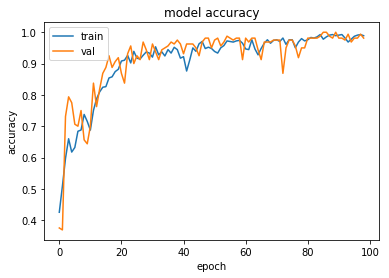

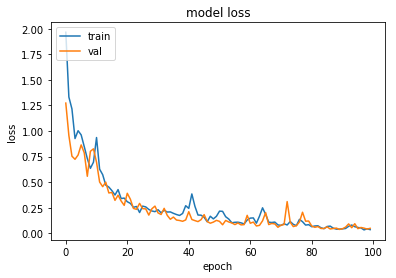

______________________________________________________________________
lr 1.000000e-04 hs 256 train accuracy: 0.983364 val accuracy: 0.981250


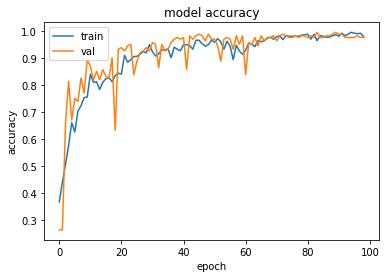

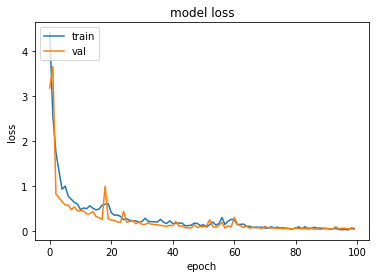

______________________________________________________________________
lr 5.000000e-04 hs 128 train accuracy: 0.966728 val accuracy: 0.981250


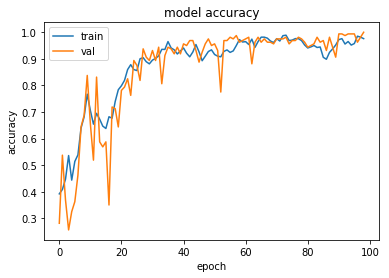

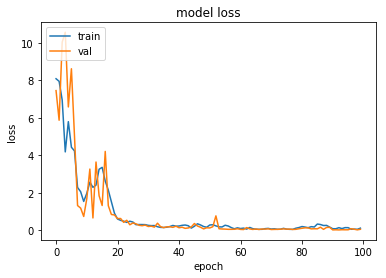

In [5]:
for indices in best_valacc_indices:
    print("______________________________________________________________________")
    print('lr %e hs %i train accuracy: %f val accuracy: %f' % results[indices])         
    plot_history(history[indices], mean_N=1)

**Based on graph and results above of the training and validation accuracy the following hyperparameters is found to be the optimal:** 
```
Learning rate       = 1e-4
Hidden size         = 256
```
**Which gives the following results for 100 epoch for 1 training run:**
```
Train accuracy      = 0.987500
Validation accuracy = 0.983364
```

## Mean and standard deviation for optimal hyperparameters <span style="color:red"> Need run with optimal param!</span>

In [4]:
history_mean_std = []
iterations = 30

# Defining the model:
model_mean_std = Sequential()
model_mean_std.add(Flatten(input_shape=(224,224,3)))
model_mean_std.add(Dense(256))
model_mean_std.add(Activation('relu'))
model_mean_std.add(Dense(3))
model_mean_std.add(Activation('softmax'))
model_mean_std.compile(loss='categorical_crossentropy',
                          optimizer=Adam(lr=1e-4),
                          metrics=['accuracy'])
model_mean_std.save_weights('temp.h5') # Saves compute power by saving initial weights

for it in range(iterations):
        # Training the model:
        temp = (model_mean_std.fit_generator(
            train_generator,
            steps_per_epoch=573 // batch_size,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=160 // batch_size))
        
        # Saving the results
        history_mean_std.append(temp)
        
        model_mean_std.load_weights('temp.h5') # Load in initials weights

Epoch 1/100
17/17 [==============================] - 6s 368ms/step - loss: 2.8521 - acc: 0.3909 - val_loss: 0.9388 - val_acc: 0.7250
Epoch 2/100
17/17 [==============================] - 6s 367ms/step - loss: 1.2318 - acc: 0.5256 - val_loss: 1.1755 - val_acc: 0.4188
Epoch 3/100
17/17 [==============================] - 6s 369ms/step - loss: 1.3744 - acc: 0.5551 - val_loss: 0.8678 - val_acc: 0.5563
Epoch 4/100
17/17 [==============================] - 6s 358ms/step - loss: 1.2677 - acc: 0.5824 - val_loss: 0.7819 - val_acc: 0.7812
Epoch 5/100
17/17 [==============================] - 6s 338ms/step - loss: 0.9312 - acc: 0.6685 - val_loss: 0.5146 - val_acc: 0.8562
Epoch 6/100
17/17 [==============================] - 6s 353ms/step - loss: 0.7833 - acc: 0.7151 - val_loss: 0.6704 - val_acc: 0.7125
Epoch 7/100
17/17 [==============================] - 6s 353ms/step - loss: 0.8028 - acc: 0.6971 - val_loss: 0.4708 - val_acc: 0.8063
Epoch 8/100
17/17 [==============================] - 6s 348ms/step - 

KeyboardInterrupt: 

In [25]:
temp = None
temp_his = []
model_mean = None
model_std = None

for h in history_mean_std:
    temp = (h.history['loss'], h.history['acc'], h.history['val_loss'], h.history['val_acc'])
    temp_his.append(temp)

temp_his = np.asarray(temp_his) # Making it to numpy array
model_mean = np.mean(temp_his, axis=0) # Calculating mean for all points
model_std = np.std(temp_his, axis=0) # Standard deviation for all points

# Brug plt.plot for at vise plots

# Printing the last value of loss, acc, vall_loss and vall_acc
string_val = ["Train Loss:     ", "Train Accuracy: ", "Valid Loss:     ", "Valid Accuracy: "]

print("----------------Mean------------------")
for index, i in enumerate(model_mean):
    print(string_val[index] + str(i[-1]))
    
print("---------Standard Deviation-----------")
for index, i in enumerate(model_std):
    print(string_val[index] + str(i[-1]))
     

----------------Mean------------------
Train Loss:     0.19606438312892993
Train Accuracy: 0.9602587796513562
Valid Loss:     0.2105408251285553
Valid Accuracy: 0.94375
---------Standard Deviation-----------
Train Loss:     0.07001356870734758
Train Accuracy: 0.019408502166681052
Valid Loss:     0.07460179030895234
Valid Accuracy: 0.025000000000000022
